In [2]:
seedNum = 888
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
import random
import statsmodels.api as sm
tf.random.set_seed(seedNum)
np.random.seed(seedNum)
import matplotlib.pyplot as plt
from tensorflow import keras
from datetime import datetime
import time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score
import sys, os
print(os.getcwd())
# os.chdir('/home/lqs/Desktop/vscproj/DeepCI')
import warnings
warnings.simplefilter('ignore')
import itertools
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils, models
from sklearn.model_selection import train_test_split

### import from our files
from mliv.dgps import get_data, get_tau_fn, fn_dict
from mliv.neuralnet.utilities import log_metrics, plot_results, hyperparam_grid,\
                                     hyperparam_mult_grid, eval_performance
from mliv.neuralnet.mnist_dgps import AbstractMNISTxz
from mliv.neuralnet import AGMM,KernelLayerMMDGMM
from mliv.neuralnet.rbflayer import gaussian, inverse_multiquadric
from mliv.neuralnet import ADeepCI

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ! pip install statsmodels

f:\DeepCI\local_notebooks


OSError: [WinError 182] 操作系统无法运行 %1。 Error loading "d:\ProgramFiles\anaconda3\lib\site-packages\torch\lib\shm.dll" or one of its dependencies.

In [27]:

#load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train/255
X_test  = X_test/255
(example_X_train,example_y_train) = (X_train[:2000], y_train[:2000])
(example_X_test,example_y_test) = (X_test[:2000], y_test[:2000])


In [28]:
a = y_train
b = X_train

In [29]:
func_run = "none"
n_epochs = 60
bs = 50

In [30]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(threshold=sys.maxsize)

In [31]:
def get_function(func_str):
    if func_str == "abs":
        return (lambda x: (-1+0.4*np.abs(x)).flatten(), 
                lambda x: (-1+0.4*torch.abs(x)).flatten())
    elif func_str == "log":
        return (lambda x: 2*np.log(np.abs(x)).flatten(), 
                lambda x: 2*torch.log(torch.abs(x)).flatten())
    elif func_str == "sin":
        return (lambda x: (0.5+0.5*np.sin(x)).flatten(), 
                lambda x: (0.5+0.5*torch.sin(x)).flatten())
    elif func_str == "none":
        return (lambda x: 0.2*x.flatten(), 
                lambda x: 0.2*torch.Tensor(x).flatten())
    else:
        return (lambda x: np.sign(np.abs(np.abs(x)-5)-2).flatten(), 
                lambda x: torch.sign(torch.abs(torch.abs(x)-5)-2).flatten())

In [32]:
def Simdata(NUM_I,seed,func,rho): #a = y_train/test, b = X_train/test
    
    np.random.seed(seed)    
    X_1_a_j = [] 
    X_2_a_j = [] 
    X_1_a_k = [] 
    X_2_a_k = [] 
    X_1_b_j = [] 
    X_2_b_j = [] 
    X_1_b_k = [] 
    X_2_b_k = []
    Z       = []
    

    X_2_a_j_t = [] 
    X_2_a_k_t = [] 
    X_2_b_j_t = [] 
    X_2_b_k_t = []

    for i in tqdm(range(0,NUM_I)):
        J = np.random.randint(4,10) # number of choice
              
        
        samplea = np.array(random.sample(list(np.arange(a.shape[0])),J)) # a list of index
        samplea = np.expand_dims(samplea, axis=1)
        ej = np.concatenate([a[i] for i in samplea],axis = None) # a list of number on images
        ej = [i for i in ej.tolist()]
        ej = np.float_(ej)

        X_1_a = np.random.uniform(-1,1,J) #customer a
        X_2_a = ej
        X_2_a_pic = [torch.Tensor(b[i]) for i in samplea]
        
        
        
        
        sampleb = np.array(random.sample(list(np.arange(a.shape[0])),J)) # a list of index
        sampleb = np.expand_dims(sampleb, axis=1)
        ej = np.concatenate([a[i] for i in sampleb],axis = None) # a list of number on images
        ej = [i for i in ej.tolist()]
        ej = np.float_(ej)
        
        X_1_b = np.random.uniform(-1,1,J) #customer b
        X_2_b = ej
        X_2_b_pic = [torch.Tensor(b[i]) for i in sampleb]
        
        
        
        xi  = np.random.normal(0,0.5,J)    # same across all customers
        
        X_2_a = X_2_a #+ rho*xi  #customer a endogeneity remove for now
        X_2_b = X_2_b #+ rho*xi  #customer b endogeneity remove for now
        
        u_a   = X_1_a + 2*func(X_2_a) + xi + np.random.normal(0,3,J) # \epsilon_{a} # 3 for score
        u_b   = X_1_b + 2*func(X_2_b) + xi + np.random.normal(0,3,J) # \epsilon_{b}
        
        choice_j = np.argmax(u_a) # return the index of product in the sample that customer a chose, we assume customer a as choose j
        choice_k = np.argmax(u_b) # return the index of product in the sample that customer b chose, we assume customer b as choose k
               
        if choice_j == choice_k:
            continue
        else:  

            X_1_a_j.append(X_1_a[choice_j])
            X_2_a_j.append(X_2_a_pic[choice_j])
            X_1_a_k.append(X_1_a[choice_k])
            X_2_a_k.append(X_2_a_pic[choice_k])
            
            X_1_b_j.append(X_1_b[choice_j]) 
            X_2_b_j.append(X_2_b_pic[choice_j]) 
            X_1_b_k.append(X_1_b[choice_k]) 
            X_2_b_k.append(X_2_b_pic[choice_k])
            
            
            
            X_2_a_j_t.append(X_2_a[choice_j])
            X_2_a_k_t.append(X_2_a[choice_k])             
            X_2_b_j_t.append(X_2_b[choice_j]) 
            X_2_b_k_t.append(X_2_b[choice_k])
            #Z.append(np.array([X_1_a[choice_j], X_2_a[choice_j], X_1_a[choice_k], X_2_a[choice_k],X_1_b[choice_j], X_2_b[choice_j], X_1_b[choice_k], X_2_b[choice_k]]))
            Z.append(np.array([X_1_a[choice_j],X_1_a[choice_k],X_1_b[choice_j],X_1_b[choice_k]]))
            
    X_2_a_j = torch.cat(X_2_a_j, out=torch.Tensor(len(X_2_a_j), 28, 28))
    X_2_a_k = torch.cat(X_2_a_k, out=torch.Tensor(len(X_2_a_k), 28, 28))
    X_2_b_j = torch.cat(X_2_b_j, out=torch.Tensor(len(X_2_b_j), 28, 28))
    X_2_b_k = torch.cat(X_2_b_k, out=torch.Tensor(len(X_2_b_k), 28, 28))

    #X_1_a_j = torch.Tensor(X_1_a_j)
    #X_1_a_k = torch.Tensor(X_1_a_k)
    #X_1_b_j = torch.Tensor(X_1_b_j)
    #X_1_b_k = torch.Tensor(X_1_b_k)
            

    
    return torch.Tensor(X_1_a_j).reshape((-1,1)).double(), X_2_a_j.unsqueeze(1), \
torch.Tensor(X_1_a_k).reshape((-1,1)).double(), X_2_a_k.unsqueeze(1), torch.Tensor(X_1_b_j).reshape((-1,1)).double(), \
X_2_b_j.unsqueeze(1), torch.Tensor(X_1_b_k).reshape((-1,1)).double(), X_2_b_k.unsqueeze(1), \
torch.tensor(Z, dtype=torch.float64),\
torch.Tensor(X_2_a_j_t).reshape((-1,1)).unsqueeze(1).double(), torch.Tensor(X_2_a_k_t).reshape((-1,1)).unsqueeze(1).double(),\
torch.Tensor(X_2_b_j_t).reshape((-1,1)).unsqueeze(1).double(), torch.Tensor(X_2_b_k_t).reshape((-1,1)).unsqueeze(1).double()

In [33]:
aa,bb = get_function(func_run)

In [34]:
X_1_a_j, X_2_a_j, X_1_a_k, X_2_a_k, X_1_b_j, X_2_b_j, X_1_b_k, X_2_b_k, Z,  X_2_a_j_t, X_2_a_k_t,  X_2_b_j_t,  X_2_b_k_t= Simdata(5000,2,aa,0.2)

100%|██████████| 5000/5000 [00:16<00:00, 310.30it/s]


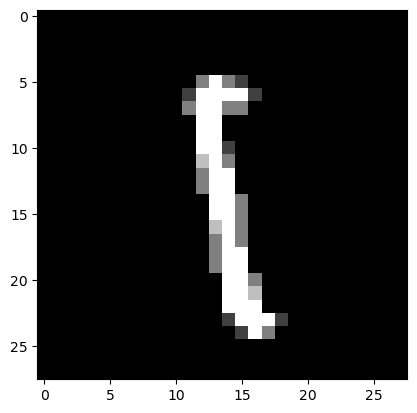

torch.Size([4140, 1, 28, 28])


In [35]:
image = X_2_a_k[6]
# plot the sample
fig = plt.figure
plt.imshow(image.squeeze(0), cmap='gray')
plt.show()

print(X_2_a_k.shape)

In [36]:
image.shape

torch.Size([1, 28, 28])

In [37]:
import sys
import os
sys.path
print(sys.path)
sys.path.append('/notebooks/AdversarialGMM/')

['/home/lqs/Desktop/vscproj/DeepCI/local_notebooks', '/home/lqs/.vscode/extensions/ms-toolsai.jupyter-2022.11.1003412109/pythonFiles', '/home/lqs/.vscode/extensions/ms-toolsai.jupyter-2022.11.1003412109/pythonFiles/lib/python', '/home/lqs/anaconda3/lib/python39.zip', '/home/lqs/anaconda3/lib/python3.9', '/home/lqs/anaconda3/lib/python3.9/lib-dynload', '', '/home/lqs/anaconda3/lib/python3.9/site-packages', '/home/lqs/anaconda3/lib/python3.9/site-packages/IPython/extensions', '/home/lqs/.ipython', '/notebooks/AdversarialGMM/']


In [38]:
device = torch.cuda.current_device() if torch.cuda.is_available() else None
print(torch.cuda.is_available())

False


In [39]:
print(device)

None


In [40]:
class CNN_Z_agmm(nn.Module):
    def __init__(self):
        super(CNN_Z_agmm, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = x  # F.log_softmax(x, dim=1)
        return output.squeeze()


class CNN_Z_kernel(nn.Module):
    def __init__(self, g_features=100):
        super(CNN_Z_kernel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, g_features)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = x  # F.log_softmax(x, dim=1)
        return output.squeeze()


class CNN_X(nn.Module):
    def __init__(self):
        super(CNN_X, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 1)
        self.finallayer = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.shape[0], 1, 28, 28)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.finallayer(x)
        output = x #F.tanh(x) #F.softmax(x, dim=1) #x
        return output.squeeze()

In [41]:
def fc_z_kernel(n_z, n_hidden, g_features, dropout_p):
    FC_Z_kernel = nn.Sequential(
        nn.Dropout(p=dropout_p),
        nn.Linear(n_z, n_hidden),
        nn.LeakyReLU(),
        nn.Dropout(p=dropout_p),
        nn.Linear(n_hidden, g_features),
        nn.ReLU(),
    )
    return FC_Z_kernel


def fc_z_agmm(n_z, n_hidden, dropout_p):
    FC_Z_agmm = nn.Sequential(
        nn.Dropout(p=dropout_p),
        nn.Linear(n_z, n_hidden),
        nn.LeakyReLU(),
        nn.Dropout(p=dropout_p),
        nn.Linear(n_hidden, 1),
    )
    return FC_Z_agmm


def fc_x(n_t, n_hidden, dropout_p):
    FC_X = nn.Sequential(
        nn.Dropout(p=dropout_p),
        nn.Linear(n_t, n_hidden),
        nn.LeakyReLU(),
        nn.Dropout(p=dropout_p),
        nn.Linear(n_hidden, 1),
    )
    return FC_X

In [42]:
k = 500
n_hidden = 300
n_instruments = 1
dropout_p = 0.1

net_learner = torch.nn.Sequential(
            torch.nn.Linear(1, k),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(k, 200),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(200, 1),
            )

#learner = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
#                        nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
#                        nn.Dropout(p=p), nn.Linear(n_hidden, 1))

#adversary_fn = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
#                             nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
#                             nn.Dropout(p=p), nn.Linear(n_hidden, 1))

net_adversary = torch.nn.Sequential(nn.Dropout(p=0.1),
            torch.nn.Linear(4, k),
            torch.nn.LeakyReLU(),
            nn.Dropout(p=0.1),                        
            torch.nn.Linear(k, 200), #200
            torch.nn.LeakyReLU(),
            nn.Dropout(p=0.1),                        
            torch.nn.Linear(200, 1),
            )
 

In [43]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
resnet50.fc = nn.Identity()
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.resnet = resnet50
        self.fc1 = nn.Linear(2048, 1)

    def forward(self, x):
        #Convolutional Layer/Pooling Layer/Activation
        x = self.resnet(x) 
        #Convolutional Layer/Dropout/Pooling Layer/Activation
        #Fully Connected Layer/Activation
        x = self.fc1(x)
        return x.squeeze()


Using cache found in /home/lqs/.cache/torch/hub/pytorch_vision_v0.10.0


In [44]:
args={}
kwargs={}
args['batch_size']=100
args['test_batch_size']=1000
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.0005 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=True

In [45]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.Normalize((0.1307,), (0.3081,))
                       
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)

import torchvision.transforms as T
transform = T.Resize((32,32))

In [46]:
def train(epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable. 
        #data = transform(data)
        #data = torch.concat([data,data,data],axis=1)
        #
        data = data.float()
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.mse_loss(output.float(), target.float())
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        data = transform(data)
        data = torch.concat([data,data,data],axis=1)
        data = data.float()
        output = model(data)
        test_loss += F.mse_loss(output, target/10)
        

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}\n'.format(
        test_loss, ))


In [47]:
class Net_X(nn.Module):
    def __init__(self):
        super(Net_X, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        # output = F.log_softmax(x, dim=1)
        return x.squeeze()


In [48]:
Net_X()

Net_X(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [49]:
model = Net_X()
if args['cuda']:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(1, 20):
    train(epoch)
    #test()

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [ ]:
d = torch.Tensor(X_train[:100]).unsqueeze(1)

In [ ]:
model(d.cuda())

In [ ]:
np.mean((model(d.cuda()).cpu().detach().numpy() - y_train[:100])**2)

In [ ]:
learner = model.to('cpu')

adversary = net_adversary.double() #fc_z_agmm(n_instruments, n_hidden, dropout_p)

In [ ]:
from mliv.neuralnet import ADeepCI

In [ ]:
res = ADeepCI(learner, adversary).fit(X_1_a_j, X_2_a_j, X_1_a_k, X_2_a_k, 
                  X_1_b_j, X_2_b_j, X_1_b_k, X_2_b_k, Z, 
            learner_l2=1e-3, adversary_l2=1e-4, adversary_norm_reg=1e-3,
            learner_lr=0.001, adversary_lr=0.001, n_epochs=3, bs=bs, train_learner_every=4, train_adversary_every=1,
            ols_weight=0., warm_start=True, logger=None, model_dir='.', device= 0, verbose=False)

In [ ]:
 model_final = model #torch.load(os.path.join(res.model_dir,"epoch{}".format(res.n_epochs - 1)))
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(X_2_a_k_t.T.squeeze().cpu().data.numpy(), model_final(X_2_a_k.cuda()).cpu().data.numpy())
plt.show()

In [ ]:
print(np.mean((X_2_a_k_t.T.squeeze().cpu().data.numpy() - model_final(X_2_a_k.cuda()).cpu().data.numpy())**2))

In [ ]:
plt.scatter(X_2_a_k_t.T.squeeze().cpu().data.numpy(), aa(X_2_a_k_t).cpu().data.numpy())
plt.show()

In [ ]:
# !pip install statsmodels

In [ ]:
import numpy as np

import statsmodels.api as sm

y = model_final(X_2_a_k).cpu().data.numpy()
x = aa(X_2_a_k_t).cpu().data.numpy()

print(np.mean((y - x) ** 2))

In [ ]:
x = sm.add_constant(x, prepend=False)

# Fit and summarize OLS model
mod = sm.OLS(y,x)

res = mod.fit()

print(res.summary())